# 循环神经网络的简洁实现
:label:`sec_rnn-concise`

虽然 :numref:`sec_rnn_scratch`
对了解循环神经网络的实现方式具有指导意义，但并不方便。
本节将展示如何使用深度学习框架的高级API提供的函数更有效地实现相同的语言模型。
我们仍然从读取时光机器数据集开始。


In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from myd2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## [**定义模型**]

高级API提供了循环神经网络的实现。
我们构造一个具有256个隐藏单元的单隐藏层的循环神经网络层`rnn_layer`。
事实上，我们还没有讨论多层循环神经网络的意义（这将在 :numref:`sec_deep_rnn`中介绍）。
现在仅需要将多层理解为一层循环神经网络的输出被用作下一层循环神经网络的输入就足够了。


In [3]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

我们(**使用张量来初始化隐状态**)，它的形状是（隐藏层数，批量大小，隐藏单元数）。


In [4]:
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

[**通过一个隐状态和一个输入，我们就可以用更新后的隐状态计算输出。**]
需要强调的是，`rnn_layer`的“输出”（`Y`）不涉及输出层的计算：
它是指每个时间步的隐状态，这些隐状态可以用作后续输出层的输入。


In [5]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

与 :numref:`sec_rnn_scratch`类似，
[**我们为一个完整的循环神经网络模型定义了一个`RNNModel`类**]。
注意，`rnn_layer`只包含隐藏的循环层，我们还需要创建一个单独的输出层。


In [6]:
#@save
class RNNModel(nn.Module):
    """循环神经网络模型"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的（之后将介绍），num_directions应该是2，否则应该是1
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,词表大小)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

🎯 整体目标

构建一个可复用的 RNN 语言模型，支持：
- 任意 RNN 类型（RNN / LSTM / GRU）
- 单向 / 双向 RNN
- 自动处理隐藏状态初始化
- 输出层映射到词表大小（用于预测下一个 token）


### 🔁 处理双向 RNN
```python
if not self.rnn.bidirectional:
    self.num_directions = 1
    self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
else:
    self.num_directions = 2
    self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)
```

#### 💡 为什么？
- **单向 RNN**：每个时间步输出维度 = `hidden_size`
- **双向 RNN**：前向 + 后向拼接 → 输出维度 = `2 * hidden_size`

> ✅ 这里自动适配输出层输入维度，确保 `Linear` 层能正确接收 RNN 输出。

---

## 🔄 二、`forward`：前向传播

```python
def forward(self, inputs, state):
    X = F.one_hot(inputs.T.long(), self.vocab_size)
    X = X.to(torch.float32)
    Y, state = self.rnn(X, state)
    output = self.linear(Y.reshape((-1, Y.shape[-1])))
    return output, state
```

### 步骤 1：输入预处理 —— **动态 one-hot 编码**
```python
X = F.one_hot(inputs.T.long(), self.vocab_size)
```

#### 输入形状假设：
- `inputs`: `(batch_size, num_steps)`，元素是 token 索引（如 `[[72,101], [108,108]]`）

#### 为什么 `.T`（转置）？
- PyTorch RNN 要求输入形状为 `(seq_len, batch_size, input_size)`
- `inputs.T` → `(num_steps, batch_size)`
- `F.one_hot(..., vocab_size)` → `(num_steps, batch_size, vocab_size)`

> ✅ 这是**字符级/词级模型的标准做法**：用 one-hot 作为 RNN 输入（无 embedding 层）



### 步骤 3：RNN 前向计算
```python
Y, state = self.rnn(X, state)
```
- `Y`: RNN 输出，形状 `(num_steps, batch_size, hidden_size * num_directions)`
- `state`: 更新后的隐藏状态（LSTM 是 `(h, c)` 元组，GRU 是张量）

---

### 步骤 4：输出层 —— **展平 + 线性变换**
```python
output = self.linear(Y.reshape((-1, Y.shape[-1])))
```

#### 为什么 `reshape((-1, Y.shape[-1]))`？
- 将 `(T, B, H)` → `(T*B, H)`，以便**全连接层处理**
- `self.linear` 输出 `(T*B, vocab_size)`
- 这是**标准做法**：对每个时间步独立预测下一个 token

> ✅ 最终 `output` 可直接用于 `CrossEntropyLoss`


## 🧠 三、`begin_state`：初始化隐藏状态

```python
def begin_state(self, device, batch_size=1):
```

### 目标：
返回符合 RNN 类型的**零初始化隐藏状态**



### 分支 1：非 LSTM（如 RNN / GRU）
```python
if not isinstance(self.rnn, nn.LSTM):
    return torch.zeros((
        self.num_directions * self.rnn.num_layers,
        batch_size,
        self.num_hiddens
    ), device=device)
```

#### 形状解释：
- `num_layers * num_directions`：层数 × 方向数（单向=1，双向=2）
- `batch_size`
- `hidden_size`

> ✅ GRU 和普通 RNN 的 `state` 是单个张量

### 分支 2：LSTM
```python
else:
    return (
        torch.zeros((...), device=device),  # hidden state h
        torch.zeros((...), device=device)   # cell state c
    )
```

#### 为什么是元组？
- LSTM 有两个内部状态：**hidden state `h`** 和 **cell state `c`**
- PyTorch 的 `nn.LSTM` 要求初始状态为 `(h0, c0)`

> ✅ 这是 PyTorch 的 API 规定

---

## 📌 四、关键设计亮点总结

| 特性 | 实现方式 | 优点 |
|------|--------|------|
| **通用 RNN 支持** | 接收任意 `rnn_layer` | 可插拔，支持 RNN/GRU/LSTM |
| **双向自动适配** | 检查 `bidirectional` | 无需手动调整输出层 |
| **动态 one-hot** | `F.one_hot` + 转置 | 适用于小词表（如字符级） |
| **状态管理** | `begin_state` 区分 LSTM/GRU | 兼容 PyTorch 所有 RNN 类型 |
| **内存高效** | 展平后线性变换 | 避免 for-loop，利用 batch 并行 |

---

## ⚠️ 五、潜在改进点（进阶思考）

1. **添加 Embedding 层**（推荐用于大词表）：
   ```python
   self.embedding = nn.Embedding(vocab_size, embed_size)
   X = self.embedding(inputs.T)  # 替代 one-hot
   ```
   - one-hot 在 `vocab_size` 很大时效率低（如 50k 单词）
   - embedding 更紧凑、可学习

2. **支持 dropout**：
   - 在 `rnn_layer` 初始化时加入 `dropout=0.5`

3. **设备自动推断**：
   - 当前需手动传 `device`，可改用 `next(self.parameters()).device`

---

## 🧪 六、使用示例

```python
# 定义 RNN 层
rnn_layer = nn.GRU(input_size=256, hidden_size=256, num_layers=2)
model = RNNModel(rnn_layer, vocab_size=1000)

# 初始化状态
state = model.begin_state(device='cpu', batch_size=32)

# 前向传播
X = torch.randint(0, 1000, (32, 10))  # (batch=32, steps=10)
output, new_state = model(X, state)
# output.shape = (320, 1000) → 320 = 32*10
```


## 训练与预测

在训练模型之前，让我们[**基于一个具有随机权重的模型进行预测**]。


In [7]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller', 10, net, vocab, device)

'time travellerrccccccccc'

很明显，这种模型根本不能输出好的结果。
接下来，我们使用 :numref:`sec_rnn_scratch`中
定义的超参数调用`train_ch8`，并且[**使用高级API训练模型**]。


困惑度 1.3, 267787.0 词元/秒 cuda:0
time travellerit s against utalo gravell isabmutter the perypece
traveller for so it will be convenimad ic bup scing han an 


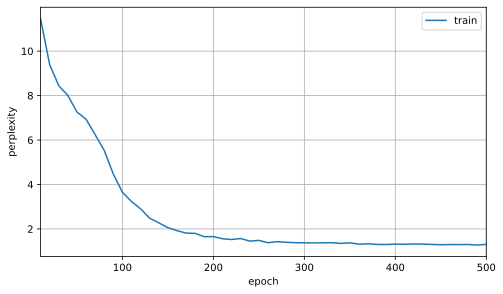

In [8]:
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)

与上一节相比，由于深度学习框架的高级API对代码进行了更多的优化，
该模型在较短的时间内达到了较低的困惑度。

## 小结

* 深度学习框架的高级API提供了循环神经网络层的实现。
* 高级API的循环神经网络层返回一个输出和一个更新后的隐状态，我们还需要计算整个模型的输出层。
* 相比从零开始实现的循环神经网络，使用高级API实现可以加速训练。

## 练习

1. 尝试使用高级API，能使循环神经网络模型过拟合吗？
1. 如果在循环神经网络模型中增加隐藏层的数量会发生什么？能使模型正常工作吗？
1. 尝试使用循环神经网络实现 :numref:`sec_sequence`的自回归模型。


[Discussions](https://discuss.d2l.ai/t/2106)




## 🎯 一、什么是双向 RNN（Bidirectional RNN）？

### 标准（单向）RNN 的局限：
- 只能利用**过去的信息**（$x_1, x_2, ..., x_t$）来建模当前状态 $h_t$
- 但在很多任务中（如命名实体识别、机器翻译、语音识别），**未来上下文**（$x_{t+1}, ..., x_T$）也非常重要！

### 双向 RNN 的核心思想：
> **同时运行两个 RNN**：
> - **前向 RNN**（forward）：从左到右，捕获历史信息 → $\vec{h}_t$
> - **后向 RNN**（backward）：从右到左，捕获未来信息 → ${\overleftarrow{h}}_t$
>
> 然后将两者**拼接**（concatenate）得到最终表示：
> $$
> h_t = [\vec{h}_t; {\overleftarrow{h}}_t] \in \mathbb{R}^{2h}
> $$

---

## 🔍 二、PyTorch 中 `nn.RNN(..., bidirectional=True)` 的行为

当你创建一个双向 RNN：

```python
rnn = nn.LSTM(
    input_size=100,
    hidden_size=256,      # 注意：这是单向的 hidden_size！
    num_layers=2,
    bidirectional=True
)
```

### ⚠️ 关键细节：
- `hidden_size=256` 表示**每个方向的隐藏层大小是 256**
- **不是总大小为 256**！
- 因此，**每个时间步的输出维度 = 256（前向） + 256（后向） = 512**

### 输出形状：
- 输入：`(seq_len, batch, input_size)`
- 输出 `Y`：`(seq_len, batch, hidden_size * 2)` ← **自动拼接**

> ✅ 这是 PyTorch 的标准设计：`bidirectional=True` ⇒ 输出维度翻倍

---

## 🧩 三、为什么输出层 `Linear` 需要调整？

在语言模型中，我们需要将 RNN 的输出映射到词表大小：

$$
\text{logits}_t = W \cdot h_t + b \quad \text{其中 } h_t \in \mathbb{R}^{d}
$$

### 情况 1：单向 RNN
- $h_t \in \mathbb{R}^{256}$
- `Linear(256, vocab_size)`

### 情况 2：双向 RNN
- $h_t \in \mathbb{R}^{512}$（256 + 256）
- 如果仍用 `Linear(256, vocab_size)` → **维度不匹配！会报错**：
  ```
  RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x512 and 256x10000)
  ```

### ✅ 正确做法：
- 单向：`Linear(hidden_size, vocab_size)`
- 双向：`Linear(hidden_size * 2, vocab_size)`

---

## 📊 四、图解对比

### 单向 RNN（unidirectional）
```
输入:  x1 → x2 → x3 → x4
       ↓    ↓    ↓    ↓
RNN:  h1 → h2 → h3 → h4     (每个 h ∈ ℝ^256)
输出:  o1   o2   o3   o4     ← Linear(256, V)
```

### 双向 RNN（bidirectional）
```
前向:  x1 → x2 → x3 → x4     → [h1_fwd, h2_fwd, h3_fwd, h4_fwd]
后向:  x1 ← x2 ← x3 ← x4     → [h1_bwd, h2_bwd, h3_bwd, h4_bwd]

拼接:  h1 = [h1_fwd; h1_bwd] ∈ ℝ^512
       h2 = [h2_fwd; h2_bwd] ∈ ℝ^512
       ...

输出:  o1, o2, o3, o4        ← Linear(512, V)
```

> 💡 注意：**双向 RNN 不能用于自回归生成**（因为需要未来信息），  
> 但**非常适合训练阶段的上下文建模**（如 BERT、序列标注）。

---

## 🔧 五、回到你的代码

```python
if not self.rnn.bidirectional:
    self.num_directions = 1
    self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
else:
    self.num_directions = 2
    self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)
```

### 这段代码做了什么？
1. **检查 RNN 是否双向**：通过 `self.rnn.bidirectional`
2. **设置方向数**：`num_directions = 1 or 2`
3. **动态创建适配的 Linear 层**：
   - 单向：输入维度 = `num_hiddens`
   - 双向：输入维度 = `num_hiddens * 2`

### 为什么需要 `num_directions`？
- 在 `begin_state` 中用于计算隐藏状态的层数：
  ```python
  num_layers * num_directions
  ```
  - 单向 LSTM：2 层 → `(2, B, H)`
  - 双向 LSTM：2 层 → `(4, B, H)`（每层有前向+后向）

---

## ⚠️ 六、重要提醒：双向 RNN 与语言模型的矛盾

虽然这段代码支持双向 RNN，但**标准语言模型**（预测下一个词）！

### 原因：
- 双向 RNN 在时间步 $t$ 使用了 $x_{t+1}, ..., x_T$（未来信息）
- 但在**生成时**，未来 token 是未知的！

### 所以：
- **训练阶段**：可以用双向 RNN 提取更强上下文（如完形填空）
- **自回归生成**（如 `predict_ch8`）：**必须用单向 RNN**

> ✅ 这段代码的通用性很好，但实际做**字符级语言模型生成**时，应传入 `bidirectional=False` 的 RNN。

---

## ✅ 总结：双向处理的核心逻辑

| 项目 | 单向 RNN | 双向 RNN |
|------|--------|--------|
| 隐藏状态维度 | `h` | `2h`（拼接） |
| 输出层输入维度 | `h` | `2h` |
| 是否可用未来信息 | ❌ 否 | ✅ 是 |
| 能否用于自回归生成 | ✅ 能 | ❌ 不能 |
| 代码适配方式 | `Linear(h, V)` | `Linear(2h, V)` |

> 💡 **设计哲学**：  
> “**根据 RNN 的实际输出维度，动态构造匹配的输出层**” —— 这是构建通用模型的关键技巧。